# AI in Medicine I - Practical 3: Transfer Learning

Generating good labels for medical datasets is an expensive and time consuming task, especially on tasks such as segmentation where expert radiologists are often required.
Often we are faced with datasets that have scarce labels or none at all and must rely on selfsupervised pretraining methods to increase our performance.
We will continue to use the brain MRI dataset from the previous practicals.
The Jupyter Notebook provided contains some preliminary code you can use and some function prototypes that you are expected to fill in.
The deliverables for the submission an archive containing the code provided completed as well as a short report explaining your strategies and choices for each task in this practical.


**Make sure to select the correct runtime when working in Google Colab (GPU)**

### Read the text descriptions and code cells carefully and look out for the cells marked with 'TASK' and 'ADD YOUR CODE HERE'.

In [ ]:
# Only run this cell when in Google Colab
! git init
! git remote add origin https://github.com/compai-lab/aim-practical-3-transfer-learning
! git fetch
! git checkout -t origin/main

Initialized empty Git repository in /content/.git/
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 35 (delta 16), reused 24 (delta 7), pack-reused 0
Unpacking objects: 100% (35/35), done.
From https://github.com/compai-lab/aim-practical-3-transfer-learning
 * [new branch]      main       -> origin/main
Branch 'main' set up to track remote branch 'main' from 'origin'.
Switched to a new branch 'main'


## Downloading the Data

In [ ]:
! wget https://www.dropbox.com/s/w9njau9t6rrheel/brainage-data.zip
! unzip brainage-data.zip #-n 
! wget https://www.dropbox.com/s/f5mt8p9pkszff3x/brainage-testdata.zip
! unzip brainage-testdata.zip #-n 

--2022-12-07 18:06:30--  https://www.dropbox.com/s/w9njau9t6rrheel/brainage-data.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/w9njau9t6rrheel/brainage-data.zip [following]
--2022-12-07 18:06:31--  https://www.dropbox.com/s/raw/w9njau9t6rrheel/brainage-data.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc8f5f792259a60ec7d3fa9f078b.dl.dropboxusercontent.com/cd/0/inline/ByPzTpEoQ4kTDsRMH9fBqcWULYDijL6hE3xE8QPnIMGbciPlkH1gFS1GjDT6tFY__aWy9XQCbpqw77NN799uuSetIG4ZhMgIoAfBUBO0G78Rr5zUCFnr_xcSPiw67IamY0ymlEo82jqWEfzDDKkEldvhDurVqSiUnaTnsqU_ytXUVQ/file# [following]
--2022-12-07 18:06:32--  https://uc8f5f792259a60ec7d3fa9f078b.dl.dropboxusercontent.com/cd/0/inline/ByPzTpEoQ4kTDsRMH9fBqcWULYDijL6hE3xE8QPnIMGbciPlkH1gFS1GjDT6tF

In [ ]:
! pip install monai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 29.0 MB/s 


## Imports

In [ ]:
from argparse import Namespace

import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch import Tensor


from monai.networks.nets import UNet
from monai.losses import DiceCELoss
from monai.transforms import AsDiscrete
from monai.metrics import compute_dice


from data_utils import get_image_dataloaders
from utils import AvgMeter, seed_everything
%load_ext tensorboard
%load_ext autoreload
%autoreload 2


In [ ]:
torch.cuda.is_available()

True

## Getting started and familiarise ourselves with the data

We provide the data of 652 subjects from which we use 500 for training, 47 for validation, and the rest for testing your final model.
The following cells provide helper functions to load the data and provide an overview and visualization of the statistics over the total population of the 652 subjects.

In [ ]:
train_df = pd.read_csv('./data/brain_age/meta/meta_data_regression_train.csv')
val_df = pd.read_csv('./data/brain_age/meta/meta_data_segmentation_train.csv')
test_df = pd.read_csv('./data/brain_age/meta/meta_data_regression_test.csv')
train_df['subject_id']
id_overlap = pd.merge(train_df, val_df, on='subject_id', how='inner')
assert len(id_overlap)==0
id_overlap = pd.merge(train_df, test_df, on='subject_id', how='inner')
assert len(id_overlap)==0
id_overlap = pd.merge(val_df, test_df, on='subject_id', how='inner')
assert len(id_overlap)==0

## Segmentation

We again wish to segment our brains using deep neural network. The following code is a basic example of how to do so.

### Full Dataset Results

In [ ]:
def train_segmentation(config, model, optimizer, train_loader, val_loader, patience=None):
    model.train()
    step = 0
    checks = 0
    best_val_loss = float('Inf')
    avg_loss = AvgMeter()
    avg_dice = AvgMeter()
    
    criterion = DiceCELoss(include_background=False, softmax=True)
    postprocess = AsDiscrete(argmax=True, to_onehot=4)

    current_patience = patience
    best_val = None #

    while True:
        for x, y in train_loader:
            x = x.to(config.device)
            y = y.to(config.device)

            # Training step
            optimizer.zero_grad()
            pred = model(x)
            loss = criterion(pred, y)
            loss.backward()
            optimizer.step()

            pred_binarized = []
            y_binarized = []
            for i in range(pred.shape[0]):
                pred_binarized.append(postprocess(pred[i]))
                y_binarized.append(postprocess(y[i]))
            pred_binarized = torch.stack(pred_binarized)
            y_binarized = torch.stack(y_binarized)

            dice = compute_dice(pred_binarized, y_binarized, include_background=False).mean()

            avg_loss.add(loss.detach().item())
            avg_dice.add(dice.detach().item())

            # Increment step
            step += 1

            if step % config.log_freq == 0 and not step % config.val_freq == 0:
                train_loss = avg_loss.compute()
                train_dice = avg_dice.compute()

            # Validate and log at validation frequency
            if step % config.val_freq == 0:
                # Reset avg_loss
                train_loss = avg_loss.compute()
                train_dice = avg_dice.compute()
                avg_loss = AvgMeter()
                avg_dice = AvgMeter()

                # Get validation results
                val_results = validate_segmentation(
                    model,
                    val_loader,
                    config,
                    criterion,
                    postprocess
                )

                # Print current performance
                print(f"Finished step {step} of {config.num_steps}. "
                      f"Train loss: {train_loss} - "
                      f"Train Dice: {train_dice} - "
                      f"val loss: {val_results['val/loss']:.4f} - "
                      f"val Dice: {val_results['val/Dice']:.4f} - "
                      f"val Dice_CSF: {val_results['val/Dice_CSF']:.4f} - "
                      f"val Dice_WM: {val_results['val/Dice_WM']:.4f} - "
                      f"val Dice_GM: {val_results['val/Dice_GM']:.4f} - ")

                # Check if the validation loss has stopped increasing
                ### ADD YOUR CODE HERE ###
                if patience is not None:
                  
                  loss = val_results['val/loss']

                  if best_val is None:
                    best_val = loss 
                    current_patience = patience
                  
                  elif best_val > loss:
                      best_val = loss 
                      current_patience = patience
                  else:
                      current_patience -= 1
                      if current_patience <= 0: 
                        print("patience exceeded"); 
                        return model, step
                  print(f"Current patience: ({current_patience}/{patience})")
                
                ### END ###
            
            if step >= config.num_steps:
                print(f'\nFinished training after {step} steps\n')
                return model, step


def validate_segmentation(model, val_loader, config, criterion, postprocess):
    model.eval()
    avg_val_loss = AvgMeter()
    avg_val_dice = AvgMeter()
    avg_val_dice_1 = AvgMeter()
    avg_val_dice_2 = AvgMeter()
    avg_val_dice_3 = AvgMeter()
    for x, y in val_loader:
        x = x.to(config.device)
        y = y.to(config.device)

        with torch.no_grad():
            pred = model(x)    
        loss = criterion(pred, y)
        
        pred_binarized = []
        y_binarized = []
        for i in range(pred.shape[0]):
            pred_binarized.append(postprocess(pred[i]))
            y_binarized.append(postprocess(y[i]))
        pred_binarized = torch.stack(pred_binarized)
        y_binarized = torch.stack(y_binarized)

        dice = compute_dice(pred_binarized, y_binarized, include_background=False)
        mean_dice = dice.mean()
        mean_dice_per_class = dice.mean(dim=0)
        avg_val_loss.add(loss.item())
        avg_val_dice.add(mean_dice.item())
        avg_val_dice_1.add(mean_dice_per_class[0].item())
        avg_val_dice_2.add(mean_dice_per_class[1].item())
        avg_val_dice_3.add(mean_dice_per_class[2].item())

        
    model.train()
    return {
        'val/loss': avg_val_loss.compute(),
        'val/Dice': avg_val_dice.compute(),
        'val/Dice_CSF': avg_val_dice_1.compute(),
        'val/Dice_WM': avg_val_dice_2.compute(),
        'val/Dice_GM': avg_val_dice_3.compute()
    }


In [ ]:
# Lets set some basic hyperparameters
config = Namespace()
config.img_size = 96
config.batch_size = 16
config.num_workers = 0

config.log_dir = './logs'
config.val_freq = 50
config.log_freq = 10

config.seed = 0
config.device = 'cuda'
config.autoencoder = False

config.lr = 1e-3
config.betas = (0.9, 0.999)

config.num_steps = 500
config.patience = 5

seed_everything(config.seed)


In [ ]:
# Load data
import pandas as pd
all_train_df = pd.read_csv('./data/brain_age/meta/meta_data_regression_train.csv')
low_data_train_df = all_train_df.sample(n=200, random_state=12)
low_data_train_df.to_csv('./data/brain_age/meta/meta_data_regression_train_lowdata_200.csv', index=False)

dataloaders_fulldata_segmentations = get_image_dataloaders(
    img_size=config.img_size,
    batch_size=config.batch_size,
    num_workers=config.num_workers,
    segmentations = True,
    low_data = '200'
)

Loading data. This might take a while...
Loading train_lowdata_200 data...
Loading val data...
Loading test data...


In [ ]:
low_data_train_df = all_train_df.sample(n=3, random_state=12)
low_data_train_df.to_csv('./data/brain_age/meta/meta_data_regression_train_lowdata_3.csv', index=False)
dataloaders_three_samples_segmentations = get_image_dataloaders(
    img_size=config.img_size,
    batch_size=config.batch_size,
    num_workers=config.num_workers,
    segmentations = True,
    low_data = '3'
)

Loading data. This might take a while...
Loading train_lowdata_3 data...
Loading val data...
Loading test data...


#### TASK: MONAI UNET
For todays exercise we will be using a library called MONAI which has some very useful tools for medical imaging. Our task is segmentation and so we will be using a classic UNet. Think about how many channels, strides and residual unets you want to include. Remember that for smaller datasets, less parameters is often an advantage. Play around with different settings and see how the performance changes.

### TASK: Low Label Simulation

Often we don't have labels for all of our samples, or have multiple datasets, where we might have labels for one dataset but not the other. 
Especially in medicine, where expert labels can be expensive to generate, we have to combine datasets to have enough data for training. 

Here we will simulate the scenario that our radiologists don't like us and have decided to only segment three brains.

Retrain the model and see what happens to our test results.

##### 1a)

######Full Data (only 200 due to RAM issues)

In [ ]:
# Init model

config.num_steps = 500

model_unet = UNet(
  spatial_dims=3,
  out_channels=4,
  ### ADD YOUR CODE HERE ###
  in_channels=1,
  channels=(64, 128, 256, 512, 1024),
  strides=(2, 2, 2, 2),
  num_res_units=1
  ### END ###
).to(config.device)


# Init optimizers
optimizer = torch.optim.AdamW(
    model_unet.parameters(),
    lr=config.lr,
    betas=config.betas
)

model_unet, step = train_segmentation(
    config=config,
    model=model_unet,
    optimizer=optimizer,
    train_loader=dataloaders_fulldata_segmentations['train'],
    val_loader=dataloaders_fulldata_segmentations['val'],
    patience = None
)

Finished step 50 of 500. Train loss: 1.3721482121944428 - Train Dice: 0.59017483741045 - val loss: 0.8540 - val Dice: 0.7450 - val Dice_CSF: 0.6894 - val Dice_WM: 0.7874 - val Dice_GM: 0.7583 - 
Finished step 100 of 500. Train loss: 0.6355738842487335 - Train Dice: 0.7684301221370697 - val loss: 0.4841 - val Dice: 0.7898 - val Dice_CSF: 0.7557 - val Dice_WM: 0.8057 - val Dice_GM: 0.8080 - 
Finished step 150 of 500. Train loss: 0.4241049337387085 - Train Dice: 0.8040700423717498 - val loss: 0.3811 - val Dice: 0.8132 - val Dice_CSF: 0.7733 - val Dice_WM: 0.8388 - val Dice_GM: 0.8275 - 
Finished step 200 of 500. Train loss: 0.35218235790729524 - Train Dice: 0.8220268070697785 - val loss: 0.3232 - val Dice: 0.8310 - val Dice_CSF: 0.8041 - val Dice_WM: 0.8451 - val Dice_GM: 0.8438 - 
Finished step 250 of 500. Train loss: 0.3154001647233963 - Train Dice: 0.8339727938175201 - val loss: 0.3055 - val Dice: 0.8337 - val Dice_CSF: 0.8038 - val Dice_WM: 0.8457 - val Dice_GM: 0.8517 - 
Finished ste

In [ ]:
# Test
test_results = validate_segmentation(model_unet, dataloaders_fulldata_segmentations['test'], config, DiceCELoss(include_background=False, softmax=True), AsDiscrete(argmax=True, to_onehot=4))
print(f'Test loss: {test_results["val/loss"]:.4f}')
print(f'Test Mean Dice: {test_results["val/Dice"]:.4f}')
print(f'Test Dice_CSF: {test_results["val/Dice_CSF"]:.4f}')
print(f'Test Dice_WM: {test_results["val/Dice_WM"]:.4f}')
print(f'Test Dice_GM: {test_results["val/Dice_GM"]:.4f}')

Test loss: 0.2449
Test Mean Dice: 0.8632
Test Dice_CSF: 0.8345
Test Dice_WM: 0.8832
Test Dice_GM: 0.8718


###### Low Data

In [ ]:
# Init model
config.num_steps = 500

model_unet = UNet(
  spatial_dims=3,
  out_channels=4,
  ### ADD YOUR CODE HERE ###
  in_channels=1,
  channels=(64, 128, 256, 512, 1024),
  strides=(2, 2, 2, 2),
  num_res_units=1
  ### END ###
).to(config.device)

# Init optimizers
optimizer = torch.optim.AdamW(
    model_unet.parameters(),
    lr=config.lr,
    betas=config.betas
)

model_unet, step = train_segmentation(
    config=config,
    model=model_unet,
    optimizer=optimizer,
    train_loader=dataloaders_three_samples_segmentations['train'],
    val_loader=dataloaders_three_samples_segmentations['val'],
    patience = None
)

Finished step 50 of 500. Train loss: 1.2798796570301056 - Train Dice: 0.5547387866675854 - val loss: 0.7516 - val Dice: 0.6751 - val Dice_CSF: 0.7247 - val Dice_WM: 0.6500 - val Dice_GM: 0.6506 - 
Finished step 100 of 500. Train loss: 0.5508114093542099 - Train Dice: 0.7581118929386139 - val loss: 0.4809 - val Dice: 0.7529 - val Dice_CSF: 0.7517 - val Dice_WM: 0.7494 - val Dice_GM: 0.7576 - 
Finished step 150 of 500. Train loss: 0.360528165102005 - Train Dice: 0.8248793411254883 - val loss: 0.4187 - val Dice: 0.7778 - val Dice_CSF: 0.7502 - val Dice_WM: 0.7944 - val Dice_GM: 0.7888 - 
Finished step 200 of 500. Train loss: 0.2737211635708809 - Train Dice: 0.862946709394455 - val loss: 0.3981 - val Dice: 0.7841 - val Dice_CSF: 0.7540 - val Dice_WM: 0.8087 - val Dice_GM: 0.7896 - 
Finished step 250 of 500. Train loss: 0.2261404064297676 - Train Dice: 0.8873860216140748 - val loss: 0.4048 - val Dice: 0.7806 - val Dice_CSF: 0.7526 - val Dice_WM: 0.7922 - val Dice_GM: 0.7970 - 
Finished step

In [ ]:
# Test
test_results = validate_segmentation(model_unet, dataloaders_three_samples_segmentations['test'], config, DiceCELoss(include_background=False, softmax=True), AsDiscrete(argmax=True, to_onehot=4))
print(f'Test loss: {test_results["val/loss"]:.4f}')
print(f'Test Mean Dice: {test_results["val/Dice"]:.4f}')
print(f'Test Dice_CSF: {test_results["val/Dice_CSF"]:.4f}')
print(f'Test Dice_WM: {test_results["val/Dice_WM"]:.4f}')
print(f'Test Dice_GM: {test_results["val/Dice_GM"]:.4f}')

Test loss: 0.5270
Test Mean Dice: 0.7375
Test Dice_CSF: 0.7001
Test Dice_WM: 0.7517
Test Dice_GM: 0.7608


Low data with a lighter model

In [ ]:
# Init model
config.num_steps = 500

model_unet = UNet(
  spatial_dims=3,
  out_channels=4,
### ADD YOUR CODE HERE ###
  in_channels=1,
  channels=(8, 16, 32),
  strides=(2, 2),
  num_res_units=1
### END ###
).to(config.device)

# Init optimizers
optimizer = torch.optim.AdamW(
    model_unet.parameters(),
    lr=config.lr,
    betas=config.betas
)

model_unet, step = train_segmentation(
    config=config,
    model=model_unet,
    optimizer=optimizer,
    train_loader=dataloaders_three_samples_segmentations['train'],
    val_loader=dataloaders_three_samples_segmentations['val'],
    patience = None
)

Finished step 50 of 500. Train loss: 1.4511582887172698 - Train Dice: 0.47436670407652853 - val loss: 0.8657 - val Dice: 0.6538 - val Dice_CSF: 0.6851 - val Dice_WM: 0.6776 - val Dice_GM: 0.5988 - 
Finished step 100 of 500. Train loss: 0.6276073879003525 - Train Dice: 0.7406572842597962 - val loss: 0.5007 - val Dice: 0.7584 - val Dice_CSF: 0.7382 - val Dice_WM: 0.7724 - val Dice_GM: 0.7647 - 
Finished step 150 of 500. Train loss: 0.3939878153800964 - Train Dice: 0.8091275823116303 - val loss: 0.4154 - val Dice: 0.7755 - val Dice_CSF: 0.7528 - val Dice_WM: 0.7859 - val Dice_GM: 0.7878 - 
Finished step 200 of 500. Train loss: 0.3189701956510544 - Train Dice: 0.8328986048698426 - val loss: 0.4044 - val Dice: 0.7734 - val Dice_CSF: 0.7509 - val Dice_WM: 0.7866 - val Dice_GM: 0.7827 - 
Finished step 250 of 500. Train loss: 0.28416440427303313 - Train Dice: 0.8469653367996216 - val loss: 0.3952 - val Dice: 0.7765 - val Dice_CSF: 0.7537 - val Dice_WM: 0.7884 - val Dice_GM: 0.7875 - 
Finished 

In [ ]:
# Test
test_results = validate_segmentation(model_unet, dataloaders_three_samples_segmentations['test'], config, DiceCELoss(include_background=False, softmax=True), AsDiscrete(argmax=True, to_onehot=4))
print(f'Test loss: {test_results["val/loss"]:.4f}')
print(f'Test Mean Dice: {test_results["val/Dice"]:.4f}')
print(f'Test Dice_CSF: {test_results["val/Dice_CSF"]:.4f}')
print(f'Test Dice_WM: {test_results["val/Dice_WM"]:.4f}')
print(f'Test Dice_GM: {test_results["val/Dice_GM"]:.4f}')

Test loss: 0.4242
Test Mean Dice: 0.7646
Test Dice_CSF: 0.7440
Test Dice_WM: 0.7888
Test Dice_GM: 0.7610


### TASK: What happens to our training dynamics and duration now that we have less data? 

Maybe setting a fixed amount of steps is not the best idea...
Implement some form of early stopping in the training loop that stops training after the validation loss does not improve after N checks.
Play around with this patience parameter. How does it affect test accuracy? Why?

Retrain the model

##### 1b)

###### Patience = 1

Full data


In [ ]:
# Init model

config.num_steps = 1500

model_unet = UNet(
  spatial_dims=3,
  out_channels=4,
  ### ADD YOUR CODE HERE ###
  in_channels=1,
  channels=(64, 128, 256, 512, 1024),
  strides=(2, 2, 2, 2),
  num_res_units=1
  ### END ###
).to(config.device)


# Init optimizers
optimizer = torch.optim.AdamW(
    model_unet.parameters(),
    lr=config.lr,
    betas=config.betas
)

model_unet, step = train_segmentation(
    config=config,
    model=model_unet,
    optimizer=optimizer,
    train_loader=dataloaders_fulldata_segmentations['train'],
    val_loader=dataloaders_fulldata_segmentations['val'],
    patience = 1
)

Finished step 50 of 1500. Train loss: 1.259537228345871 - Train Dice: 0.6245452640950679 - val loss: 0.7502 - val Dice: 0.7444 - val Dice_CSF: 0.7266 - val Dice_WM: 0.7565 - val Dice_GM: 0.7502 - 
Current patience: (1/1)
Finished step 100 of 1500. Train loss: 0.5778371769189835 - Train Dice: 0.7745440304279327 - val loss: 0.4595 - val Dice: 0.7936 - val Dice_CSF: 0.7639 - val Dice_WM: 0.8041 - val Dice_GM: 0.8127 - 
Current patience: (1/1)
Finished step 150 of 1500. Train loss: 0.41196369647979736 - Train Dice: 0.8051218032836914 - val loss: 0.3705 - val Dice: 0.8128 - val Dice_CSF: 0.7848 - val Dice_WM: 0.8240 - val Dice_GM: 0.8295 - 
Current patience: (1/1)
Finished step 200 of 1500. Train loss: 0.3464971667528152 - Train Dice: 0.8230078387260437 - val loss: 0.3298 - val Dice: 0.8290 - val Dice_CSF: 0.7978 - val Dice_WM: 0.8467 - val Dice_GM: 0.8426 - 
Current patience: (1/1)
Finished step 250 of 1500. Train loss: 0.3098099064826965 - Train Dice: 0.8356594312191009 - val loss: 0.2952

In [ ]:
# Test
test_results = validate_segmentation(model_unet, dataloaders_fulldata_segmentations['test'], config, DiceCELoss(include_background=False, softmax=True), AsDiscrete(argmax=True, to_onehot=4))
print(f'Test loss: {test_results["val/loss"]:.4f}')
print(f'Test Mean Dice: {test_results["val/Dice"]:.4f}')
print(f'Test Dice_CSF: {test_results["val/Dice_CSF"]:.4f}')
print(f'Test Dice_WM: {test_results["val/Dice_WM"]:.4f}')
print(f'Test Dice_GM: {test_results["val/Dice_GM"]:.4f}')

Test loss: 0.2169
Test Mean Dice: 0.8787
Test Dice_CSF: 0.8481
Test Dice_WM: 0.8966
Test Dice_GM: 0.8916


###### Patience = 3

In [ ]:
# Init model

config.num_steps = 1500

model_unet = UNet(
  spatial_dims=3,
  out_channels=4,
  ### ADD YOUR CODE HERE ###
  in_channels=1,
  channels=(64, 128, 256, 512, 1024),
  strides=(2, 2, 2, 2),
  num_res_units=1
  ### END ###
).to(config.device)


# Init optimizers
optimizer = torch.optim.AdamW(
    model_unet.parameters(),
    lr=config.lr,
    betas=config.betas
)


model_unet, step = train_segmentation(
    config=config,
    model=model_unet,
    optimizer=optimizer,
    train_loader=dataloaders_fulldata_segmentations['train'],
    val_loader=dataloaders_fulldata_segmentations['val'],
    patience = 3
)

Finished step 50 of 1500. Train loss: 1.4028234434127809 - Train Dice: 0.6125217396020889 - val loss: 0.9856 - val Dice: 0.7367 - val Dice_CSF: 0.6988 - val Dice_WM: 0.7771 - val Dice_GM: 0.7341 - 
Current patience: (3/3)
Finished step 100 of 1500. Train loss: 0.7693973767757416 - Train Dice: 0.769859150648117 - val loss: 0.5891 - val Dice: 0.7932 - val Dice_CSF: 0.7614 - val Dice_WM: 0.8160 - val Dice_GM: 0.8021 - 
Current patience: (3/3)
Finished step 150 of 1500. Train loss: 0.5009734404087066 - Train Dice: 0.8050364863872528 - val loss: 0.4239 - val Dice: 0.8135 - val Dice_CSF: 0.7781 - val Dice_WM: 0.8392 - val Dice_GM: 0.8231 - 
Current patience: (3/3)
Finished step 200 of 1500. Train loss: 0.3829127645492554 - Train Dice: 0.8252110433578491 - val loss: 0.3403 - val Dice: 0.8355 - val Dice_CSF: 0.8085 - val Dice_WM: 0.8527 - val Dice_GM: 0.8454 - 
Current patience: (3/3)
Finished step 250 of 1500. Train loss: 0.3281923246383667 - Train Dice: 0.8372536528110505 - val loss: 0.3022 

In [ ]:
# Test
test_results = validate_segmentation(model_unet, dataloaders_fulldata_segmentations['test'], config, DiceCELoss(include_background=False, softmax=True), AsDiscrete(argmax=True, to_onehot=4))
print(f'Test loss: {test_results["val/loss"]:.4f}')
print(f'Test Mean Dice: {test_results["val/Dice"]:.4f}')
print(f'Test Dice_CSF: {test_results["val/Dice_CSF"]:.4f}')
print(f'Test Dice_WM: {test_results["val/Dice_WM"]:.4f}')
print(f'Test Dice_GM: {test_results["val/Dice_GM"]:.4f}')

Test loss: 0.2284
Test Mean Dice: 0.8746
Test Dice_CSF: 0.8476
Test Dice_WM: 0.8931
Test Dice_GM: 0.8831


###### Patience = 5

In [ ]:
# Init model

config.num_steps = 1500

model_unet = UNet(
  spatial_dims=3,
  out_channels=4,
  ### ADD YOUR CODE HERE ###
  in_channels=1,
  channels=(64, 128, 256, 512, 1024),
  strides=(2, 2, 2, 2),
  num_res_units=1
  ### END ###
).to(config.device)


# Init optimizers
optimizer = torch.optim.AdamW(
    model_unet.parameters(),
    lr=config.lr,
    betas=config.betas
)


model_unet, step = train_segmentation(
    config=config,
    model=model_unet,
    optimizer=optimizer,
    train_loader=dataloaders_fulldata_segmentations['train'],
    val_loader=dataloaders_fulldata_segmentations['val'],
    patience = 5
)

Finished step 50 of 1500. Train loss: 1.4928445982933045 - Train Dice: 0.6303780573606491 - val loss: 1.0310 - val Dice: 0.7458 - val Dice_CSF: 0.7238 - val Dice_WM: 0.7716 - val Dice_GM: 0.7420 - 
Current patience: (5/5)
Finished step 100 of 1500. Train loss: 0.7872813940048218 - Train Dice: 0.7721231019496918 - val loss: 0.5884 - val Dice: 0.7921 - val Dice_CSF: 0.7577 - val Dice_WM: 0.8197 - val Dice_GM: 0.7989 - 
Current patience: (5/5)
Finished step 150 of 1500. Train loss: 0.49413695335388186 - Train Dice: 0.8073405599594117 - val loss: 0.4224 - val Dice: 0.8163 - val Dice_CSF: 0.7843 - val Dice_WM: 0.8398 - val Dice_GM: 0.8246 - 
Current patience: (5/5)
Finished step 200 of 1500. Train loss: 0.37985936224460604 - Train Dice: 0.8266067779064179 - val loss: 0.3469 - val Dice: 0.8312 - val Dice_CSF: 0.8076 - val Dice_WM: 0.8436 - val Dice_GM: 0.8424 - 
Current patience: (5/5)
Finished step 250 of 1500. Train loss: 0.3284655034542084 - Train Dice: 0.8377623379230499 - val loss: 0.30

In [ ]:
# Test
test_results = validate_segmentation(model_unet, dataloaders_fulldata_segmentations['test'], config, DiceCELoss(include_background=False, softmax=True), AsDiscrete(argmax=True, to_onehot=4))
print(f'Test loss: {test_results["val/loss"]:.4f}')
print(f'Test Mean Dice: {test_results["val/Dice"]:.4f}')
print(f'Test Dice_CSF: {test_results["val/Dice_CSF"]:.4f}')
print(f'Test Dice_WM: {test_results["val/Dice_WM"]:.4f}')
print(f'Test Dice_GM: {test_results["val/Dice_GM"]:.4f}')

Test loss: 0.2332
Test Mean Dice: 0.8733
Test Dice_CSF: 0.8468
Test Dice_WM: 0.8924
Test Dice_GM: 0.8808


###### Patience = 20

In [ ]:
# Init model

config.num_steps = 2500

model_unet = UNet(
  spatial_dims=3,
  out_channels=4,
  ### ADD YOUR CODE HERE ###
  in_channels=1,
  channels=(64, 128, 256, 512, 1024),
  strides=(2, 2, 2, 2),
  num_res_units=1
  ### END ###
).to(config.device)


# Init optimizers
optimizer = torch.optim.AdamW(
    model_unet.parameters(),
    lr=config.lr,
    betas=config.betas
)


model_unet, step = train_segmentation(
    config=config,
    model=model_unet,
    optimizer=optimizer,
    train_loader=dataloaders_fulldata_segmentations['train'],
    val_loader=dataloaders_fulldata_segmentations['val'],
    patience = 20
)

Finished step 50 of 2500. Train loss: 1.3228802728652953 - Train Dice: 0.5454224462807179 - val loss: 0.8437 - val Dice: 0.7102 - val Dice_CSF: 0.7365 - val Dice_WM: 0.7718 - val Dice_GM: 0.6223 - 
Current patience: (20/20)
Finished step 100 of 2500. Train loss: 0.662089307308197 - Train Dice: 0.7553989791870117 - val loss: 0.5294 - val Dice: 0.7789 - val Dice_CSF: 0.7577 - val Dice_WM: 0.8041 - val Dice_GM: 0.7749 - 
Current patience: (20/20)
Finished step 150 of 2500. Train loss: 0.4460502117872238 - Train Dice: 0.7994874942302704 - val loss: 0.3853 - val Dice: 0.8138 - val Dice_CSF: 0.7871 - val Dice_WM: 0.8325 - val Dice_GM: 0.8218 - 
Current patience: (20/20)
Finished step 200 of 2500. Train loss: 0.36462404906749724 - Train Dice: 0.8177605998516083 - val loss: 0.3374 - val Dice: 0.8240 - val Dice_CSF: 0.7971 - val Dice_WM: 0.8396 - val Dice_GM: 0.8353 - 
Current patience: (20/20)
Finished step 250 of 2500. Train loss: 0.32067589223384857 - Train Dice: 0.8323949456214905 - val los

In [ ]:
# Test
test_results = validate_segmentation(model_unet, dataloaders_fulldata_segmentations['test'], config, DiceCELoss(include_background=False, softmax=True), AsDiscrete(argmax=True, to_onehot=4))
print(f'Test loss: {test_results["val/loss"]:.4f}')
print(f'Test Mean Dice: {test_results["val/Dice"]:.4f}')
print(f'Test Dice_CSF: {test_results["val/Dice_CSF"]:.4f}')
print(f'Test Dice_WM: {test_results["val/Dice_WM"]:.4f}')
print(f'Test Dice_GM: {test_results["val/Dice_GM"]:.4f}')

Test loss: 0.2640
Test Mean Dice: 0.8647
Test Dice_CSF: 0.8373
Test Dice_WM: 0.8822
Test Dice_GM: 0.8747


### TASK: Autoencoder

We can't seem to achieve our previous performance because we don't have enough labeled samples. We still have the rest of the data, we just don't have any labels. Maybe we can improve our performance by doing some initial unsupervised learning over the full, unlabeled dataset before finetuning on our three labeled samples.

In [ ]:
def train_autoencoder(config, model, optimizer, train_loader, val_loader):
    model.train()
    step = 0
    avg_loss = AvgMeter()

    while True:
        for x, y in train_loader:
            x = x.to(config.device)
            y = y.to(config.device)
            

            # Training step
            optimizer.zero_grad()
            pred = model(x)
            loss = torch.pow((pred - x), 2).mean()
            loss.backward()
            optimizer.step()

            avg_loss.add(loss.detach().item())

            # Increment step
            step += 1

            # Validate and log at validation frequency
            if step % config.val_freq == 0:
                # Reset avg_loss
                train_loss = avg_loss.compute()
                avg_loss = AvgMeter()

                # Get validation results
                val_results = validate_autoencoder(
                    model,
                    val_loader,
                    config
                )

                # Print current performance
                print(f"Finished step {step} of {config.num_steps}. "
                      f"Train loss: {train_loss} - "
                      f"val loss: {val_results['val/loss']:.4f} - "
                      f"val MAE: {val_results['val/MAE']:.4f}")

            if step >= config.num_steps:
                print(f'\nFinished training after {step} steps\n')
                return model, step


def validate_autoencoder(model, val_loader, config, show_plot=False):
    model.eval()
    avg_val_loss = AvgMeter()
    preds = []
    targets = []
    for x, y in val_loader:
        x = x.to(config.device)
        y = y.to(config.device)

        with torch.no_grad():
            pred = model(x)
        loss = torch.pow((pred - x), 2).mean()
        avg_val_loss.add(loss.item())
        preds.append(pred.cpu())
        targets.append(x.cpu())

    preds = torch.cat(preds)
    targets = torch.cat(targets)
    mae = mean_absolute_error_image(preds, targets)
        
    model.train()
    return {
        'val/loss': avg_val_loss.compute(),
        'val/MAE': mae,
    }


def mean_absolute_error_image(preds: Tensor, targets: Tensor) -> float:
    """Compute the mean absolute error between predictions and targets"""
    return (preds - targets).abs().mean().item()


In [ ]:
# Init model
# HINT: If you aren´t getting the performance you expect, try to change the number of channels and the number of res units
model_ae = UNet(
  ### ADD YOUR CODE HERE ###
  spatial_dims=3,
  in_channels=1,
  out_channels=1,
  channels=(64, 128, 256, 512, 1024),
  strides=(2, 2, 2, 2),
  num_res_units=1
  ### END ###
).to(config.device)

# Init optimizers
optimizer = torch.optim.AdamW(
    model_ae.parameters(),
    lr=config.lr,
    betas=config.betas
)

config.num_steps = 500
model_ae, step = train_autoencoder(
    config=config,
    model=model_ae,
    optimizer=optimizer,
    train_loader=dataloaders_fulldata_segmentations['train'],
    val_loader=dataloaders_fulldata_segmentations['val']
)

Finished step 50 of 500. Train loss: 0.09078470021486282 - val loss: 0.0309 - val MAE: 0.0791
Finished step 100 of 500. Train loss: 0.018056584876030683 - val loss: 0.0100 - val MAE: 0.0492
Finished step 150 of 500. Train loss: 0.007635535458102822 - val loss: 0.0058 - val MAE: 0.0388
Finished step 200 of 500. Train loss: 0.00505463982000947 - val loss: 0.0042 - val MAE: 0.0334
Finished step 250 of 500. Train loss: 0.0037314259028062226 - val loss: 0.0031 - val MAE: 0.0293
Finished step 300 of 500. Train loss: 0.0028844643756747246 - val loss: 0.0025 - val MAE: 0.0263
Finished step 350 of 500. Train loss: 0.0023323838552460076 - val loss: 0.0020 - val MAE: 0.0238
Finished step 400 of 500. Train loss: 0.0019341895473189651 - val loss: 0.0017 - val MAE: 0.0218
Finished step 450 of 500. Train loss: 0.0016603336902335287 - val loss: 0.0015 - val MAE: 0.0203
Finished step 500 of 500. Train loss: 0.0014521137089468538 - val loss: 0.0013 - val MAE: 0.0190

Finished training after 500 steps



#### TASK: Visualize Results

Plot both the original brains and the reconstructed brains above one another to see how good the autoencoder performed

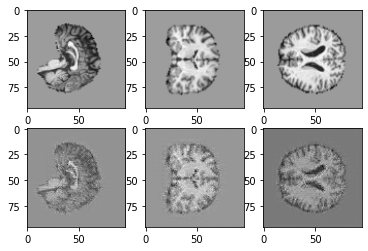

In [ ]:
orig_images = next(iter(dataloaders_fulldata_segmentations['val']))[0].to(config.device)

f, axarr = plt.subplots(2, 3)
orig_image = orig_images[0, 0].cpu().numpy()
H, W, D = orig_image.shape
axarr[0][0].imshow(orig_image[H // 2, :, :], cmap='gray')
axarr[0][1].imshow(orig_image[:, W // 2, :], cmap='gray')
axarr[0][2].imshow(orig_image[:, :, D // 2], cmap='gray')
### ADD YOUR CODE HERE ###
pred = model_ae(next(iter(dataloaders_fulldata_segmentations['val']))[0].to(config.device))
pred = pred[0, 0].detach().cpu().numpy()
H, W, D = pred.shape
axarr[1][0].imshow(pred[H // 2, :, :], cmap='gray')
axarr[1][1].imshow(pred[:, W // 2, :], cmap='gray')
axarr[1][2].imshow(pred[:, :, D // 2], cmap='gray')

### END ###
plt.show()

Looks pretty good! 

#### TASK: Transfer Learning
Now lets see if its learned any useful features that can help us in our segmentation task

In [ ]:
torch.cuda.empty_cache()

In [ ]:
# Init model
model_ae_segmenter = UNet(
  ### ADD YOUR CODE HERE ###
  spatial_dims=3,
  in_channels=1,
  out_channels=4,
  channels=(64, 128, 256, 512, 1024),
  strides=(2, 2, 2, 2, 2),
  num_res_units=1
  ### END ###
).to(config.device)

# Init optimizers
optimizer = torch.optim.AdamW(
    model_ae_segmenter.parameters(),
    lr=config.lr,
    betas=config.betas
)

# Load the weights from the autoencoder using the state_dict
# HINT: Remove the weights from the decoder as we have a different number of channels now and a different task. 
# HINT: Take a look at the arguments if you get errors that might be ok to ignore
### ADD YOUR CODE HERE ###

weights = model_ae.state_dict() # load autoencoder's weights
layers = []
print("Model's state_dict:")
for key in model_ae.state_dict():
    print(key, "\t", model_ae.state_dict()[key].size())
    layers.append(key)

start_layer_decoder = 'model.1.submodule.1.submodule.1.submodule.2.0.conv.weight' #layers[len(layers) // 2 + 2] # beginning of decoder

flag = True
for key in model_ae.state_dict():
    if key == start_layer_decoder:
        flag = False
    if not flag:
        weights.update({key: model_ae_segmenter.state_dict()[key]})  # delete decoder weights

# save weights
PATH = 'model_encoder_weights.pth'
torch.save(weights, PATH)
for key in weights:
    print(key, "\t",weights[key].size())
### END ###

# Sometimes after pretraining in very low data regimes it can help to freeze the encoder, to preserve the features learned over the large dataset.
# Write some code to freeze only the encoder here
### ADD YOUR CODE HERE ###

# freeze encoder
model_ae_segmenter.load_state_dict(weights)
flag = True
for name, param in model_ae_segmenter.named_parameters():
    if name == start_layer_decoder: flag = False
    if flag: param.requires_grad = False
    else: param.requires_grad = True
config.num_steps = 10000

for key in model_ae_segmenter.state_dict():
    print((model_ae.state_dict()[key] == model_ae_segmenter.state_dict()[key]).all())

### END ###


/usr/local/lib/python3.8/dist-packages/monai/networks/nets/unet.py:139: UserWarning: `len(strides) > len(channels) - 1`, the last 1 values of strides will not be used.
  warnings.warn(f"`len(strides) > len(channels) - 1`, the last {delta} values of strides will not be used.")


Model's state_dict:
model.0.conv.unit0.conv.weight 	 torch.Size([64, 1, 3, 3, 3])
model.0.conv.unit0.conv.bias 	 torch.Size([64])
model.0.conv.unit0.adn.A.weight 	 torch.Size([1])
model.0.residual.weight 	 torch.Size([64, 1, 3, 3, 3])
model.0.residual.bias 	 torch.Size([64])
model.1.submodule.0.conv.unit0.conv.weight 	 torch.Size([128, 64, 3, 3, 3])
model.1.submodule.0.conv.unit0.conv.bias 	 torch.Size([128])
model.1.submodule.0.conv.unit0.adn.A.weight 	 torch.Size([1])
model.1.submodule.0.residual.weight 	 torch.Size([128, 64, 3, 3, 3])
model.1.submodule.0.residual.bias 	 torch.Size([128])
model.1.submodule.1.submodule.0.conv.unit0.conv.weight 	 torch.Size([256, 128, 3, 3, 3])
model.1.submodule.1.submodule.0.conv.unit0.conv.bias 	 torch.Size([256])
model.1.submodule.1.submodule.0.conv.unit0.adn.A.weight 	 torch.Size([1])
model.1.submodule.1.submodule.0.residual.weight 	 torch.Size([256, 128, 3, 3, 3])
model.1.submodule.1.submodule.0.residual.bias 	 torch.Size([256])
model.1.submodule.

In [ ]:
model_ae_segmenter.eval()

In [ ]:
# Train
model_ae_segmenter, step = train_segmentation(
    config=config,
    model=model_ae_segmenter,
    optimizer=optimizer,
    train_loader=dataloaders_three_samples_segmentations['train'],
    val_loader=dataloaders_three_samples_segmentations['val']
)

Finished step 50 of 10000. Train loss: 1.3415868306159973 - Train Dice: 0.5800491891801357 - val loss: 0.7652 - val Dice: 0.7351 - val Dice_CSF: 0.7167 - val Dice_WM: 0.7765 - val Dice_GM: 0.7122 - 
Finished step 100 of 10000. Train loss: 0.5547724866867065 - Train Dice: 0.784317125082016 - val loss: 0.4884 - val Dice: 0.7606 - val Dice_CSF: 0.7465 - val Dice_WM: 0.7904 - val Dice_GM: 0.7450 - 
Finished step 150 of 10000. Train loss: 0.37636174976825715 - Train Dice: 0.8205219209194183 - val loss: 0.4070 - val Dice: 0.7834 - val Dice_CSF: 0.7639 - val Dice_WM: 0.8006 - val Dice_GM: 0.7858 - 
Finished step 200 of 10000. Train loss: 0.3188935261964798 - Train Dice: 0.8359005522727966 - val loss: 0.3756 - val Dice: 0.7932 - val Dice_CSF: 0.7769 - val Dice_WM: 0.8075 - val Dice_GM: 0.7952 - 
Finished step 250 of 10000. Train loss: 0.2817144465446472 - Train Dice: 0.8504007744789124 - val loss: 0.3704 - val Dice: 0.7916 - val Dice_CSF: 0.7802 - val Dice_WM: 0.8073 - val Dice_GM: 0.7872 - 
F

In [ ]:
# Test
test_results = validate_segmentation(model_ae_segmenter, dataloaders_fulldata_segmentations['test'], config, DiceCELoss(include_background=False, softmax=True), AsDiscrete(argmax=True, to_onehot=4))
print(f'Test loss: {test_results["val/loss"]:.4f}')
print(f'Test Dice: {test_results["val/Dice"]:.4f}')
print(f'Test Dice_CSF: {test_results["val/Dice_CSF"]:.4f}')
print(f'Test Dice_WM: {test_results["val/Dice_WM"]:.4f}')
print(f'Test Dice_GM: {test_results["val/Dice_GM"]:.4f}')

Test loss: 0.3608
Test Dice: 0.7939
Test Dice_CSF: 0.7767
Test Dice_WM: 0.8183
Test Dice_GM: 0.7868


Nice! It looks like we were able to boost our mean Dice score by 2-3 points.

#### TASK: Frozen vs Unfrozen Weights
Retrain the model above, this time with fully trainable weights. How does our performance change? Why do you think this is?

#### TASK: Autoencoder Performance VS Downstream Task
 
We can definitely improve our autoencoder reconstruction performance by training for longer. Maybe this isn't ideal for our segmentation task, but we can try it out. Try training for different number of steps and see how the reconstruction performance changes. What is the best number of steps?

# Bonus


## MedicalNet: Using Pretrained Weights from the Internet

Often times it helps to use weights trained by other people on larger datasets. In 3D Medical Imaging for example, MedicalNet (https://github.com/Tencent/MedicalNet) is a collection of 3D ResNets that have been trained on 23 segmentation datasets. Although there are other organs included, see how well the learned weights transfer to our task. Download and and use MedicalNet for our segmentation task. Is this better than selfsupervised training over dataset?